# Python notebook to load and analyze zebrafish larvae data

## Author: Gautam Reddy, December 2019. 

In [1]:
#load libraries
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from copy import deepcopy
from scipy.interpolate import splev, splprep,interp1d
rc('text', usetex=True)
from sklearn import mixture
import scipy.stats as stats
import time
from hmmlearn import hmm
from sklearn.decomposition import PCA
import matplotlib as mpl
import palettable
from cycler import cycler

#defines a bout class similar to Olivier's struct in MATLAB
class bout:
    def __init__(self, vec):
        self.numPoiss =  vec[0][0][0]
        self.begMove =  vec[1][0][0]
        self.endMove =  vec[2][0][0]
        self.boutnum = 0
        self.tailAngle =  vec[3][:,0]
        self.posHeadX =  vec[4][:,0]
        self.posHeadY =  vec[5][:,0]
        self.rawheading =  vec[6][:,0]
        self.correctedheading =  vec[7][:,0]
        self.posTailXVideoReferential =  vec[8]
        self.posTailYVideoReferential =  vec[9]
        self.posTailXHeadingReferential =  vec[10]
        self.posTailYHeadingReferential=  vec[11]
        self.tailAngleSmoothed=  vec[14][:,0]
        self.freq =  vec[15][0,:]
        self.freqX=  vec[16][0,:]
        self.freqY =  vec[17][:,0]
        self.param =  vec[18][0,:]
        self.posHeadX_int = self.posHeadX
        self.posHeadY_int = self.posHeadY
        self.speed = 0
        self.frequency = 0
        self.amp = 0
        self.nosc = 0
        self.angspeed = 0
        self.deltahead = 0
        self.time = 0 
        self.dist = 0
        self.disp = 0
        self.avgspeed = 0
        self.ispeeds = np.zeros(25)
        self.welltype = 0
        self.filename = 0
        self.wellnum = 0
        self.likelihood = 0
        self.taillength = 0
        self.tailarea = 0
        self.tailpc1 = 0
        self.tailpc2 = 0
        self.tailpc3 = 0
        self.tailangles = np.zeros((30,7))
        self.ibi_prev = 0
        self.ibi_next = 0
        self.warning = []
        

# Define functions to calculate different quantities from each bout

All the functions required to calculate kinematic variables from bout data are defined here

In [2]:
#Interpolate the positions of the larva head
def bout_posHead_interp(b):
    f,u = splprep([b.posHeadX + .1*np.random.randn(len(b.posHeadX)), b.posHeadY + .1*np.random.randn(len(b.posHeadX))],s = 10)
    new_points = splev(u, f)
    return new_points[0], new_points[1]

#Speed in mm/sec
def speed(b, fps, px_to_mm):
    totaldist = dist(b,px_to_mm)
    totaltime = time(b,fps)
    return totaldist/totaltime

#Instantaneous speed in mm/sec
def ispeed(b, fps, px_to_mm):
    numps = 6
    ispeeds = np.zeros(25)
    for j in range(min(len(b.posHeadX)-1,25)):
        if j >= len(b.posHeadX):
            ispeeds[j] = 0
        else:
            bXs = np.concatenate((b.posTailXVideoReferential[j][-numps:],[b.posHeadX[j]]))
            bYs = np.concatenate((b.posTailYVideoReferential[j][-numps:],[b.posHeadY[j]]))
            theta = np.arctan2((bYs[-1]-bYs[0]),(bXs[-1]-bXs[0]))
            delx = (b.posHeadY_int[j+1] - b.posHeadY_int[j])*px_to_mm
            dely = (b.posHeadX_int[j+1] - b.posHeadX_int[j])*px_to_mm
            del_ = np.sqrt(delx**2 + dely**2)
            phi = np.arctan2(dely,delx)
            ispeeds[j] = del_*np.cos(theta - phi)*fps
    return ispeeds

#Frequency of oscillations in Hz
def frequency(b,fps):
    if len(b.freqX) > 1:
        return 0.5/(np.mean(b.freqX[1:] - b.freqX[:-1])/fps)
    else:
        return 0
    
#Amplitude of oscillations
def amp(b):
    return np.max(np.abs(b.freqY))*180/np.pi

#Number of oscillations
def nosc(b):
    return len(b.freq)

#Mean angular speed in deg/sec
def angspeed(b,fps):
    totaltime = time(b,fps)
    return deltahead(b)/totaltime

#Heading change in degrees
def deltahead(b):
    numps = 6
    bXs = np.concatenate((b.posTailXVideoReferential[0][-numps:],[b.posHeadX[0]]))
    bYs = np.concatenate((b.posTailYVideoReferential[0][-numps:],[b.posHeadY[0]]))
    slope0 = np.arctan2((bYs[-1]-bYs[0]),(bXs[-1]-bXs[0]))*180/np.pi
    
    bXs = np.concatenate((b.posTailXVideoReferential[-1][-numps:],[b.posHeadX[-1]]))
    bYs = np.concatenate((b.posTailYVideoReferential[-1][-numps:],[b.posHeadY[-1]]))
    slope1 = np.arctan2((bYs[-1]-bYs[0]),(bXs[-1]-bXs[0]))*180/np.pi
    delt = -(slope1 - slope0)
    if delt > 180:
        return 360 - delt
    elif delt < -180:
        return -(360 + delt)
    else:
        return delt

#Bout time in seconds
def time(b,fps):
    return len(b.posHeadX)/fps

#total distance travelled in mm
def dist(b,px_to_mm):
    dist1 = 0
    for j in range(len(b.posHeadX)-1):
        dist1 += np.sqrt((b.posHeadX_int[j+1] - b.posHeadX_int[j])**2 + (b.posHeadY_int[j+1] - b.posHeadY_int[j])**2)
    return dist1*px_to_mm

#magnitude of displacement in mm
def disp(b,px_to_mm):
    disp1 = np.sqrt((b.posHeadX_int[-1] - b.posHeadX_int[0])**2 + (b.posHeadY_int[-1] - b.posHeadY_int[0])**2)
    return disp1*px_to_mm

#Average speed in mm/s
def avgspeed(b,fps,px_to_mm):
    disp1 = disp(b,px_to_mm)
    return disp1/time(b,fps)

#avg tail length in. mm
def taillength(b):
    return np.sum(np.abs(np.diff(b.tailAngleSmoothed)))

#tail integral
def tailarea(b):
    return np.abs(np.sum(b.tailAngleSmoothed))

#tailangles for all points
def tailangles(b):
    numps = 3
    
    headx = b.posHeadX
    heady = b.posHeadY
    tailx = b.posTailXVideoReferential
    taily = b.posTailYVideoReferential
    
    tailangles_arr = np.zeros((30,7))
    for i in range(min(len(b.posHeadX),tailangles_arr.shape[0])):
        ang = np.arctan2(heady[i] - taily[i][-3],headx[i] - tailx[i][-3])*180/np.pi
        for j in range(tailangles_arr.shape[1]):
            ang2 = np.arctan2(heady[i] - taily[i][j],headx[i] - tailx[i][j])*180/np.pi
            delang = ang2 - ang
            if np.abs(delang) < 180:
                tailangles_arr[i,j] = delang
            elif delang > 180:
                tailangles_arr[i,j] = delang - 360
            elif delang < -180:
                tailangles_arr[i,j] = 360 + delang
            #print(i,j,ang,ang2,tailangles_arr[i,j])
    return tailangles_arr

#calculate heading
def heading(b):
    return np.arctan2(b.posHeadY_int[-1] - b.posHeadY_int[-2],b.posHeadX_int[-1] - b.posHeadX_int[-2])*180.0/np.pi

# Define general parameters and other functions to process data

These are general functions to proces the data. The first part of this cell is the definition of various parameters that are used throughout the analysis. This is followed by 

(1) reject: the criterion to reject mis-identified bouts 

(2) get_bouts_dataset: a function to load the bout data given a set of filenames. This puts all bout data from the different files into a single large array of bouts. 

(3) pool_data: a function to pool all data corresponding to different variables in a common struct. This is to easily plot scatter plots and histograms of individual variables

(4) collect_two_consecutive_bouts and collect_three_consecutive_bouts: two functions to collect sequences of two and three consecutive bouts for later analysis into the history-dependence of the bouts

(5) collect_trajectories: Split the data from the large array of bouts in (2) into a collection of trajectories i.e., data from a single larva in a particular well. 

(6) get_avgloglikelihood: Compute average abnormality of a sequence of bouts

(7) get_loglikelihoodtrace: take a trajectory and split into sequences of bouts that last T seconds each and calculate their avg abnormality using (6)

(8) get_loglikelihoodtrace_dataset: Do (7) for the entire dataset

In [3]:
px_to_mm = 0.071

speedrange = [0,25]
frequencyrange = [10,40]
amprange = [0,75]
noscrange = [0,15]
angspeedrange = [-300,300]
deltaheadrange = [-120,120]
timerange = [0,0.6]
distrange = [0,9]
disprange = [0,9]
avgspeedrange = [0,25]
tailarearange = [0,10]


vartypes = {'speeds':speedrange, 'frequencys':frequencyrange,'amps':amprange,'noscs':noscrange,'angspeeds':angspeedrange,'deltaheads':deltaheadrange,'dists':distrange,'times':timerange, 'disps':disprange, 'avgspeeds':avgspeedrange, 'tailareas':tailarearange}

#Reject bouts that are bad based on heuristics
def reject(b):
    if b.time < 0.04 or b.time > 1.2:
        return True
    if b.dist > 25 or b.dist < 0.0 :
        return True
    if b.speed > 50 or b.speed < 1:
        return True
    if np.abs(b.deltahead) > 180:
        return True
    return False

def get_bouts_dataset(foldername, filenames, welltypes, fps,exp_type):
    bouts_all = []
    
    for k,f in enumerate(filenames):
        name = foldername + f + '/results_' + f + '.mat'
        data = sio.loadmat(name)
        welltype = welltypes[k]
        numrejects = 0
        numaccepts = 0
        
        for j in range(len(welltype)):
            if exp_type != welltype[j]:
                continue
            
            if data['videoDataResults'][0][0][0][0][j][0][0].shape[0] == 0:
                continue
            numbouts = data['videoDataResults'][0][0][0][0][j][0][0][0].shape[0]
            for i in range(numbouts):
                bouts_temp = data['videoDataResults'][0][0][0][0][j][0][0][0][i]
                #print(len(bouts_temp[0][0]))
                b = bout(bouts_temp[0][0])
                b.boutnum = i
                b.posHeadX_int,b.posHeadY_int = bout_posHead_interp(b)
                b.speed = speed(b,fps,px_to_mm)
                b.frequency = frequency(b,fps)
                b.amp = amp(b)
                b.nosc = nosc(b)
                b.angspeed = angspeed(b,fps)
                b.deltahead = deltahead(b)
                b.time = time(b,fps)
                b.dist = dist(b, px_to_mm)
                b.disp = disp(b, px_to_mm)
                b.avgspeed = avgspeed(b,fps,px_to_mm)
                b.welltype = welltype[j]
                b.filename = f
                b.taillength = taillength(b)
                b.tailarea = tailarea(b)
                b.tailangles = tailangles(b)
                b.ispeeds = ispeed(b,fps,px_to_mm)
                b.wellnum = j
                if i < numbouts-1:
                    bouts_temp_next = data['videoDataResults'][0][0][0][0][j][0][0][0][i+1]
                    b_next = bout(bouts_temp_next[0][0])
                    b.ibi_next = (b_next.begMove - b.endMove)/fps
                if i > 0:
                    bouts_temp_prev = data['videoDataResults'][0][0][0][0][j][0][0][0][i-1]
                    b_prev = bout(bouts_temp_prev[0][0])
                    b.ibi_prev = (b.begMove - b_prev.endMove)/fps

                if reject(b):
                    numrejects += 1
                    continue
                else:
                    numaccepts += 1
                bouts_all += [b]
        print(name,numrejects, numaccepts, 1.0*numrejects/(numaccepts + numrejects + 1))
    return bouts_all


#Pool together bout information from a dataset and store in a dictionary
def pool_data(bout_dataset):
    numbouts = len(bout_dataset)
    data_collected = {'speeds':np.zeros(numbouts), 'frequencys':np.zeros(numbouts),'amps':np.zeros(numbouts),'noscs':np.zeros(numbouts),'angspeeds':np.zeros(numbouts),'deltaheads':np.zeros(numbouts),'dists':np.zeros(numbouts)\
                      ,'times':np.zeros(numbouts),'avgspeeds':np.zeros(numbouts),'disps':np.zeros(numbouts),'tailareas':np.zeros(numbouts)}
    
    for i,b in enumerate(bout_dataset):
        data_collected['speeds'][i] = b.speed
        data_collected['frequencys'][i] = b.frequency
        data_collected['amps'][i] = b.amp
        data_collected['noscs'][i] = b.nosc
        data_collected['angspeeds'][i] = b.angspeed
        data_collected['deltaheads'][i] = b.deltahead
        data_collected['times'][i] = b.time
        data_collected['dists'][i] = b.dist
        data_collected['disps'][i] = b.disp
        data_collected['avgspeeds'][i] = b.avgspeed
        data_collected['tailareas'][i] = b.tailarea
    return data_collected

#Collect two bout info
def collect_two_consecutive_bouts(bout_dataset, fps, px_to_mm):
    collection = []
    currfilename = bout_dataset[0].filename
    currwellnum = bout_dataset[0].wellnum
    for i,b in enumerate(bout_dataset[:-1]):
        b_next = bout_dataset[i+1]
        if b_next.filename == currfilename and b_next.wellnum == currwellnum:
            ibi = (b_next.begMove - b.endMove)/fps
            dist_bout = px_to_mm*np.sqrt((b_next.posHeadX[0] - b.posHeadX[-1])**2 + (b_next.posHeadY[0] - b.posHeadY[-1])**2)
            if ibi > 10 or dist_bout > 4:
                continue
            else:
                collection += [[b,b_next,ibi]]
        else:
            currfilename = b_next.filename
            currwellnum = b_next.wellnum
    return collection

#Collect three bout info
def collect_three_consecutive_bouts(bout_dataset, fps, px_to_mm):
    collection = []
    currfilename = bout_dataset[0].filename
    currwellnum = bout_dataset[0].wellnum
    for i,b in enumerate(bout_dataset[:-2]):
        b_next = bout_dataset[i+1]
        b_nextnext = bout_dataset[i+2]
        if (b_next.filename == currfilename and b_next.wellnum == currwellnum) and (b_nextnext.filename == currfilename and b_nextnext.wellnum == currwellnum):
            ibi = (b_next.begMove - b.endMove)/fps
            ibi2 = (b_nextnext.begMove - b_next.endMove)/fps
            dist_bout = px_to_mm*np.sqrt((b_next.posHeadX[0] - b.posHeadX[-1])**2 + (b_next.posHeadY[0] - b.posHeadY[-1])**2)
            dist_bout2 = px_to_mm*np.sqrt((b_nextnext.posHeadX[0] - b_next.posHeadX[-1])**2 + (b_nextnext.posHeadY[0] - b_next.posHeadY[-1])**2)

            if (ibi > 10 or dist_bout > 4) or (ibi2 > 10 or dist_bout2 > 4):
                continue
            else:
                collection += [[b,b_next,b_nextnext]]
        else:
            currfilename = b_next.filename
            currwellnum = b_next.wellnum
    return collection

#Collect four bout info
def collect_four_consecutive_bouts(bout_dataset, fps, px_to_mm):
    collection = []
    currfilename = bout_dataset[0].filename
    currwellnum = bout_dataset[0].wellnum
    for i,b in enumerate(bout_dataset[:-3]):
        b_next = bout_dataset[i+1]
        b_nextnext = bout_dataset[i+2]
        b_nextnextnext = bout_dataset[i+3]
        if (b_next.filename == currfilename and b_next.wellnum == currwellnum) and (b_nextnext.filename == currfilename and b_nextnext.wellnum == currwellnum) and (b_nextnextnext.filename == currfilename and b_nextnextnext.wellnum == currwellnum):
            ibi = (b_next.begMove - b.endMove)/fps
            ibi2 = (b_nextnext.begMove - b_next.endMove)/fps
            ibi3 = (b_nextnextnext.begMove - b_nextnext.endMove)/fps
            dist_bout = px_to_mm*np.sqrt((b_next.posHeadX[0] - b.posHeadX[-1])**2 + (b_next.posHeadY[0] - b.posHeadY[-1])**2)
            dist_bout2 = px_to_mm*np.sqrt((b_nextnext.posHeadX[0] - b_next.posHeadX[-1])**2 + (b_nextnext.posHeadY[0] - b_next.posHeadY[-1])**2)
            dist_bout3 = px_to_mm*np.sqrt((b_nextnextnext.posHeadX[0] - b_nextnext.posHeadX[-1])**2 + (b_nextnextnext.posHeadY[0] - b_nextnext.posHeadY[-1])**2)


            if (ibi > 10 or dist_bout > 4) or (ibi2 > 10 or dist_bout2 > 4) or (ibi3 > 10 or dist_bout3 > 4):
                continue
            else:
                collection += [[b,b_next,b_nextnext, b_nextnextnext]]
        else:
            currfilename = b_next.filename
            currwellnum = b_next.wellnum
    return collection

#Collect continuous set of bouts
def collect_trajectories(bout_dataset, fps, px_to_mm):
    collection = []
    currfilename = bout_dataset[0].filename
    currwellnum = bout_dataset[0].wellnum
    currtraj = [bout_dataset[0]]
    for i,b in enumerate(bout_dataset[:-1]):
        b_next = bout_dataset[i+1]
        if b_next.filename == currfilename and b_next.wellnum == currwellnum:
            currtraj += [b_next]
        else:
            if len(currtraj) > 30:
                collection += [currtraj]
            currtraj = [b_next]
            currfilename = b_next.filename
            currwellnum = b_next.wellnum
    return collection

#Collect continuous set of bouts with no spacings between bouts
def collect_trajectories_nospacings(bout_dataset, fps, px_to_mm):
    collection = []
    currfilename = bout_dataset[0].filename
    currwellnum = bout_dataset[0].wellnum
    currtraj = [bout_dataset[0]]
    for i,b in enumerate(bout_dataset[:-1]):
        b_next = bout_dataset[i+1]
        ibi = (b_next.begMove - b.endMove)/fps
        dist_bout = px_to_mm*np.sqrt((b_next.posHeadX[0] - b.posHeadX[-1])**2 + (b_next.posHeadY[0] - b.posHeadY[-1])**2)
        if b_next.filename == currfilename and b_next.wellnum == currwellnum and ibi < 5 and dist_bout < 4:
            currtraj += [b_next]
        else:
            if len(currtraj) > 30:
                collection += [currtraj]
            currtraj = [b_next]
            currfilename = b_next.filename
            currwellnum = b_next.wellnum
    return collection

def collect_data_hmm(trajs_nospacings):
    nsamples = 0
    for t in trajs_nospacings:
        nsamples += len(t)

    data_hmm = np.zeros((nsamples,6))
    lengths = np.zeros(len(trajs_nospacings), dtype = int)
    for i,t in enumerate(trajs_nospacings):
        lengths[i] = len(t)
        for j in range(len(t)):
            data_hmm[np.sum(lengths[:i])+j][0] = np.abs(t[j].deltahead)
            data_hmm[np.sum(lengths[:i])+j][1] = t[j].speed
            data_hmm[np.sum(lengths[:i])+j][2] = t[j].taillength
            data_hmm[np.sum(lengths[:i])+j][3] = t[j].tailpc1
            data_hmm[np.sum(lengths[:i])+j][4] = t[j].tailpc2
            data_hmm[np.sum(lengths[:i])+j][5] = t[j].tailpc3
            
    return data_hmm, lengths

def collect_data_hmm_other(trajs_nospacings):
    nsamples = 0
    for t in trajs_nospacings:
        nsamples += len(t)

    data_hmm = np.zeros((nsamples,4))
    lengths = np.zeros(len(trajs_nospacings), dtype = int)
    for i,t in enumerate(trajs_nospacings):
        lengths[i] = len(t)
        for j in range(len(t)):
            data_hmm[np.sum(lengths[:i])+j][0] = np.mean(t[j].posHeadX)
            data_hmm[np.sum(lengths[:i])+j][1] = np.mean(t[j].posHeadY)
            data_hmm[np.sum(lengths[:i])+j][2] = t[j].dist
            data_hmm[np.sum(lengths[:i])+j][3] = t[j].angspeed
            
    return data_hmm, lengths

def collect_trajectory_hmm(traj_nospacings):
    data_hmm = np.zeros((len(traj_nospacings),4))
    for j in range(len(traj_nospacings)):
        data_hmm[j][0] = np.abs(traj_nospacings[j].angspeed)*1e-3
        data_hmm[j][1] = traj_nospacings[j].speed
        data_hmm[j][2] = traj_nospacings[j].time
        data_hmm[j][3] = traj_nospacings[j].amp
        
    return data_hmm

def get_tailangles(dataset):
    tailangles_all = np.zeros((len(dataset),112))
    for i,b in enumerate(dataset):
        tailangles_all[i] = np.abs(b.tailangles[:16,:].flatten())
    return tailangles_all

def update_tail_pcas(bouts,pcs):
    for i,b in enumerate(bouts):
        b.tailpc1 = pcs[i,0]
        b.tailpc2 = pcs[i,1]
        b.tailpc3 = pcs[i,2]
        b.tailpc4 = pcs[i,3]
    return bouts


In [4]:
#Implementation of Gaussian Mixture Model used for clustering. 

class GMM_model:
    def __init__(self,numclasses,lamb = 0):
        self.numclasses = numclasses
        self.lamb = lamb
        
    def E_step(self,datasets):
        N = datasets.shape[1]
        numsets = datasets.shape[0]
        gamma_ = np.zeros((numsets,N,self.numclasses))
        for k in range(self.numclasses):
            gamma_[:,:,k] = 1e-20 + self.weights_[:,k][:,np.newaxis]*stats.multivariate_normal.pdf(datasets,mean = self.means_[k],cov = self.covars_[k])
        gamma_ = gamma_/np.sum(gamma_,axis=2)[:,:,np.newaxis]
        return gamma_
    
    def M_step(self,datasets,gamma_):
        N = datasets.shape[1]
        for k in range(self.numclasses):
            Nk = np.sum(gamma_[:,:,k])
            self.means_[k] = np.sum(np.sum(gamma_[:,:,k][:,:,None]*datasets,axis=1),axis=0)/Nk
            outerprod = (datasets - self.means_[k])[:,:,:,None]*(datasets - self.means_[k])[:,:,None,:]
            self.covars_[k] = np.sum(np.sum(gamma_[:,:,k][:,:,None,None]*outerprod,axis=1),axis=0)/Nk
        
        if datasets.shape[0] == 2:
            weights1 = self.weights_[0] + 1e-20
            weights2 = self.weights_[1] + 1e-20
            mid = 0.5*(weights1 + weights2) + 1e-20
            kl1 = stats.entropy(weights1,0.5*weights1+0.5*weights2)
            kl2 = stats.entropy(weights2,0.5*weights1+0.5*weights2)
            self.weights_[0] = (np.sum(gamma_[0],axis=0) + N*self.lamb*weights1*np.log(weights1/mid) + 1)/(np.sum(gamma_[0]) + N*self.lamb*kl1 + self.numclasses)
            self.weights_[1] = (np.sum(gamma_[1],axis=0) + N*self.lamb*weights2*np.log(weights2/mid) + 1)/(np.sum(gamma_[1]) + N*self.lamb*kl2 + self.numclasses)
            #print(kl1,kl2)
        else:
            self.weights_ = np.sum(gamma_,axis=1)/np.sum(gamma_,axis=(1,2))[:,None]
            
    def LL(self,datasets):
        N = datasets.shape[1]
        numsets = datasets.shape[0]
        temp = np.zeros((numsets,N))
        for k in range(self.numclasses):
            temp += self.weights_[:,k][:,None]*stats.multivariate_normal.pdf(datasets,mean = self.means_[k],cov = self.covars_[k])
        LL = np.mean(np.log(temp + 1e-80))
        return -LL
        
    def solve(self,datasets):
        numsets= len(datasets)
        self.dim = datasets.shape[2]
        N = datasets.shape[1]
        self.means_ = np.zeros((self.numclasses,self.dim))
        self.covars_ = np.zeros((self.numclasses, self.dim,self.dim))
        self.weights_ = np.zeros((numsets,self.numclasses))
        
        datasets_flat = np.reshape(datasets,(-1,datasets.shape[2]))
        covar = np.cov(datasets_flat, rowvar = False)
        mean = np.mean(datasets_flat, axis = 0)
        
        numinits = 20
        means_init = np.zeros((numinits,self.numclasses,self.dim))
        covars_init = np.zeros((numinits,self.numclasses,self.dim,self.dim))
        weights_init = np.zeros((numinits,numsets,self.numclasses))
        LL_init = np.zeros(numinits)
        for init_ in range(numinits):
            for i in range(self.numclasses):
                means_init[init_][i] = np.random.multivariate_normal(mean,covar)
                covars_init[init_][i] = deepcopy(covar)

            for j in range(numsets):
                weights_init[init_][j] = np.random.dirichlet(5*np.ones(self.numclasses))
            self.means_ = means_init[init_]
            self.covars_ = covars_init[init_]
            self.weights_ = weights_init[init_]
            LL_init[init_] = self.LL(datasets)
        best = np.argmin(LL_init)
        self.means_ = means_init[best]
        self.covars_ = covars_init[best]
        self.weights_ = weights_init[best]
            
        LL_curr = self.LL(datasets)
        LL_prev = 0
        print("Initial negative log-likelihood per sample = %.4f" %LL_curr)
        num = 0
        while np.abs(LL_curr - LL_prev) > 1e-4:
            gamma_= self.E_step(datasets)
            self.M_step(datasets,gamma_)
            LL_prev = LL_curr
            LL_curr = self.LL(datasets)
            num += 1
            #print(LL_curr)
        print("Final negative log-likelihood per sample = %.4f" %LL_curr)
        print("Number of iterations = %d" %num)
        
    def _compute_posterior(self,Y,set_index):
        post = np.zeros(self.numclasses)
        for k in range(self.numclasses):
            post[k] = self.weights_[set_index][k]*self._compute_likelihood(Y,k)
        return post/np.sum(post)
    
    def _compute_likelihood_sequence(self,Y,s):
        return stats.multivariate_normal.pdf(Y,mean = self.means_[s],cov = self.covars_[s])
        
    def _compute_likelihood(self,y,s):
        return stats.multivariate_normal.pdf(y,mean = self.means_[s],cov = self.covars_[s])
    
    def _compute_log_likelihood(self,data):
        Y = np.zeros((len(data),self.numclasses))
        for k in range(self.numclasses):
            Y[:,k] = np.log(stats.multivariate_normal.pdf(data,mean = self.means_[k],cov = self.covars_[k]) + 1e-80)
        return Y
    def score(self,dataset,set_index):
        temp = np.zeros(len(dataset))
        for k in range(self.numclasses):
            temp += self.weights_[set_index,k]*stats.multivariate_normal.pdf(dataset,mean = self.means_[k],cov = self.covars_[k])
        LL = np.sum(np.log(temp + 1e-80))
        return LL
        
    def _generate_sample_from_state(self,s):
        return np.random.multivariate_normal(self.means_[s],self.covars_[s])
    
    def _read_params(self,means_,covars_,weights_):
        self.numclasses = means_.shape[0]
        self.means_ = means_
        self.covars_ = covars_
        self.weights_ = weights_
        
    def _save_params(self,filename):
        np.save(filename + "_means",self.means_)
        np.save(filename + "_covars",self.covars_)
        np.save(filename + "_weights",self.weights_)
            
        

# Collect bouts from exploration, homogpH, sharppH and gradient pH data

## Load data. For each dataset, write down the list of filenames to load from and specify the welltypes for each experiment. 

## Key for welltypes: 0 -- exploratory, 1 -- acid on left, -1 -- acid on right, 2 -- homogenous pH, 3 -- double sharp pH, 4 -- bad data, 5 -- paramecia, 6 -- paramecia_explo

## The output shows the loaded filename, the number of bouts rejected, accepted and the ratio of rejects to total number of bouts



In [5]:
#input the name of the folder where the data is located
foldername = './resultsMay2019/Catamaran_pH_2a/'
filenames = []
filenames += ['Catamaran_pH_2a_t1a']
filenames += ['Catamaran_pH_2a_t2']
filenames += ['Catamaran_pH_2a_t3']
filenames += ['Catamaran_pH_2a_t4']
filenames += ['Catamaran_pH_2a_t5']
filenames += ['Catamaran_pH_2a_t6']
filenames += ['Catamaran_pH_2a_t7']

fps = 160.0
welltypes = []
for i in range(len(filenames)):
    if i < 4:
        welltypes += [[0,0,0,0,0,0,3,3,3,3,3,3]]
    else:
        welltypes += [[0,0,0,0,0,0,2,2,2,2,2,2]]
    
#bad data
welltypes[0][6] = 4
welltypes[2][9] = 4
welltypes[3][7] = 4
        
bouts_explo1 = get_bouts_dataset(foldername, filenames, welltypes, fps, 0)
bouts_dbsharppH1 = get_bouts_dataset(foldername, filenames, welltypes, fps,3)

foldername = './resultsForSB1/ZZoutput/'
filenames = []
filenames += ['Catamaran_pH_1a_t1a']
filenames += ['Catamaran_pH_1a_t1b']
filenames += ['Catamaran_pH_1a_t2a']
filenames += ['Catamaran_pH_1a_t2b']
filenames += ['Catamaran_pH_1a_t3a']
filenames += ['Catamaran_pH_1a_t4a']
filenames += ['Catamaran_pH_1a_t1c']
filenames += ['Catamaran_pH_1a_t2c']
filenames += ['Catamaran_pH_1a_t3c']
filenames += ['Catamaran_pH_1a_t4c']

welltypes = []
for i in range(len(filenames)):
    if i < 6:
        welltypes += [[0,0,0,3,3,3,3,3,3,0,0,0]]
    else:
        welltypes += [[0,0,0,0,0,0,2,2,2,2,2,2]]
bouts_explo2 = get_bouts_dataset(foldername, filenames, welltypes, fps, 0)
bouts_dbsharppH2 = get_bouts_dataset(foldername, filenames, welltypes, fps,3)

foldername = './Catamaran_pH_2bTxtOnly/'
filenames = []
filenames += ['Catamaran_pH_2b_t1']
filenames += ['Catamaran_pH_2b_t2']
filenames += ['Catamaran_pH_2b_t3']
filenames += ['Catamaran_pH_2b_t4']
filenames += ['Catamaran_pH_2b_t5']
filenames += ['Catamaran_pH_2b_t6']
filenames += ['Catamaran_pH_2b_t8']

welltypes = []
for i in range(len(filenames)):
    welltypes += [[0,0,0,0,0,0,3,3,3,3,3,3]]
    
welltypes[0][8] = 4
welltypes[4][7] = 4
welltypes[5][9] = 4
welltypes[6][8] = 4

bouts_explo3 = get_bouts_dataset(foldername, filenames, welltypes, fps, 0)
bouts_dbsharppH3 = get_bouts_dataset(foldername, filenames, welltypes, fps, 3)


foldername = './Catamaran_pH_2cTxtOnly/'
filenames = []
filenames += ['Catamaran_pH_2c_t1']
filenames += ['Catamaran_pH_2c_t2']
filenames += ['Catamaran_pH_2c_t3']
filenames += ['Catamaran_pH_2c_t4']
filenames += ['Catamaran_pH_2c_t5']
filenames += ['Catamaran_pH_2c_t6']
filenames += ['Catamaran_pH_2c_t7']
filenames += ['Catamaran_pH_2c_t8']

welltypes = []
for i in range(len(filenames)):
    welltypes += [[0,0,0,0,0,0,3,3,3,3,3,3]]
    
bouts_explo4 = get_bouts_dataset(foldername, filenames, welltypes, fps, 0)
bouts_dbsharppH4 = get_bouts_dataset(foldername, filenames, welltypes, fps, 3)


./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t1a/results_Catamaran_pH_2a_t1a.mat 4 4807 0.0008312551953449709
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t2/results_Catamaran_pH_2a_t2.mat 5 4269 0.0011695906432748538
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t3/results_Catamaran_pH_2a_t3.mat 14 4775 0.0029227557411273487


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t4/results_Catamaran_pH_2a_t4.mat 18 3567 0.0050195203569436695
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t5/results_Catamaran_pH_2a_t5.mat 2 1076 0.0018535681186283596
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t6/results_Catamaran_pH_2a_t6.mat 3 1004 0.002976190476190476
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t7/results_Catamaran_pH_2a_t7.mat 2 809 0.0024630541871921183
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t1a/results_Catamaran_pH_2a_t1a.mat 15 2850 0.0052337752965806
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t2/results_Catamaran_pH_2a_t2.mat 7 4094 0.0017064846416382253
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t3/results_Catamaran_pH_2a_t3.mat 11 2700 0.004056047197640118
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t4/results_Catamaran_pH_2a_t4.mat 2 3643 0.0005485463521667581
./resultsMay2019/Catamaran_pH_2a/Catamaran_pH_2a_t5/results_Catamaran_pH_2a_t5.mat 0 0 0.0
./resultsMay20

# Pool, organize data, get IBIs and continuous trajectories

In [6]:
#pool data
bouts_explo = bouts_explo1 + bouts_explo2 + bouts_explo3 + bouts_explo4
bouts_dbsharppH = bouts_dbsharppH1 + bouts_dbsharppH2 + bouts_dbsharppH3 + bouts_dbsharppH4

#gather tail angle data for PCA
ta_explo = get_tailangles(bouts_explo)
ta_dbsharppH = get_tailangles(bouts_dbsharppH)

ta_all = np.concatenate((ta_explo,ta_dbsharppH))
pca = PCA()
pca.fit(ta_all)

pcs_explo = pca.transform(ta_explo)
pcs_dbsharppH = pca.transform(ta_dbsharppH)

#add PC components into bout information
bouts_explo = update_tail_pcas(bouts_explo,pcs_explo)
bouts_dbsharppH = update_tail_pcas(bouts_dbsharppH,pcs_dbsharppH)
 
#concatenate bouts into a list   
trajs_explo_nospacings = collect_trajectories_nospacings(bouts_explo, fps, px_to_mm)
trajs_dbsharppH_nospacings = collect_trajectories_nospacings(bouts_dbsharppH, fps, px_to_mm)

#collect data used as input to BASS
data_explo_hmm, lengths_explo_hmm = collect_data_hmm(trajs_explo_nospacings)
data_dbsharppH_hmm, lengths_dbsharppH_hmm = collect_data_hmm(trajs_dbsharppH_nospacings)

#flattened list of trajectories
trajs_explo_flat = []
for t in trajs_explo_nospacings:
    trajs_explo_flat += t
    
trajs_dbsharppH_flat = []
for t in trajs_dbsharppH_nospacings:
    trajs_dbsharppH_flat += t

#collected other variables 
data_explo_hmm_other, lengths_explo_hmm_other = collect_data_hmm_other(trajs_explo_nospacings)
data_dbsharppH_hmm_other, lengths_dbsharppH_hmm_other = collect_data_hmm_other(trajs_dbsharppH_nospacings)

#These are loaded in the BASS algorithm code. 
#They contain the six parameters - speed, delta head, tail length and first three PCs
#for every bout recorded in our experiments. 

#the files with the "other" suffix contain other auxiliary variables. 

# np.save("data_explo_hmm",data_explo_hmm)
# np.save("data_dbsharppH_hmm",data_dbsharppH_hmm)

# np.save("lengths_explo_hmm",lengths_explo_hmm)
# np.save("lengths_dbsharppH_hmm",lengths_dbsharppH_hmm)

# np.save("data_explo_hmm_other",data_explo_hmm_other)
# np.save("data_dbsharppH_hmm_other",data_dbsharppH_hmm_other)

#pool all data
data_explo = pool_data(bouts_explo)
data_dbsharppH = pool_data(bouts_dbsharppH)

#collect pairs of consecutive bouts -- used to plot distribution of inter-bout intervals
collection_explo_2bout = collect_two_consecutive_bouts(bouts_explo, fps, px_to_mm)
collection_dbsharppH_2bout = collect_two_consecutive_bouts(bouts_dbsharppH, fps, px_to_mm)

ibis_explo = []
for i in range(len(collection_explo_2bout)):
    ibis_explo += [collection_explo_2bout[i][2]]
    
ibis_dbsharppH = []
for i in range(len(collection_dbsharppH_2bout)):
    ibis_dbsharppH += [collection_dbsharppH_2bout[i][2]]
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:203: RuntimeWarning: overflow encountered in ushort_scalars


In [9]:
#check if number of bouts match
print(len(trajs_dbsharppH_flat), len(data_dbsharppH_hmm))
print(len(trajs_explo_flat), len(data_explo_hmm))

66009 66009
84749 84749


# Plot distribution of IBIs
## unused for paper

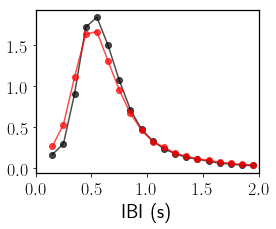

In [12]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize = 18)

n,bins = np.histogram(ibis_explo, bins = np.linspace(0.1,2,20), density = True)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins,n,'o-' , color = 'k', alpha = 0.7)
lamb = 1.5/np.mean(ibis_explo)

n,bins = np.histogram(ibis_dbsharppH, bins = np.linspace(0.1,2,20), density = True)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins,n,'o-' , color = 'r', alpha = 0.7)
axis.set_xlim(0,2)

axis.set_xlabel("IBI (s)" , fontsize = 20)
plt.show()

# Plot histogram of variables in acid and explo

-0.5939112832285076
-0.6145044247892546
7.701182083199619 8.315686507988874


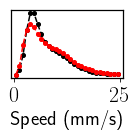

In [15]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (2,2))
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize = 22)

def plot_histogram(axis,data, var, nbins, ls,c):
    varlow = vartypes[var][0]
    varhigh = vartypes[var][1]
    n,bins = np.histogram(data[var], bins = np.linspace(varlow,varhigh,nbins), density = True)
    bins = 0.5*(bins[1:] + bins[:-1])
    axis.plot(bins,n, ls, color = c, alpha = 1, ms = 4)
        
var = 'speeds' #can be speeds, times, deltaheads, amps, noscs, etc. 
nbins = 30
plot_histogram(axis,data_explo, var, nbins, 'o--','k')
plot_histogram(axis,data_dbsharppH, var, nbins, 'o--','r')
axis.set_xlabel(r"Speed (mm/s)", fontsize = 20)
#axis.set_xlabel(r"Duration (s)", fontsize = 20)
#axis.set_xlabel(r"$\Delta$heading (deg)", fontsize = 20)
axis.set_yticks([])

fig.tight_layout()
print(np.median(data_explo[var])-np.median(data_dbsharppH[var]))
print(np.mean(data_explo[var])-np.mean(data_dbsharppH[var]))
print(np.mean(data_explo[var]),np.mean(data_dbsharppH[var]))
plt.show()

# Plot scatter plots of two variables

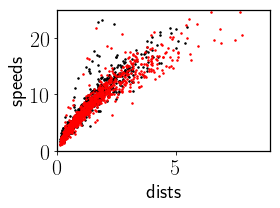

In [18]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))

var1 = 'dists'
var2 = 'speeds'

var1low = vartypes[var1][0]
var2low = vartypes[var2][0]

var1hi = vartypes[var1][1]
var2hi = vartypes[var2][1]

subsample = 1000
explo_subsample = np.random.randint(0,len(data_explo['angspeeds']), subsample)
axis.plot(data_explo[var1][explo_subsample], data_explo[var2][explo_subsample], 'ko', ms = 1.5)

dbsharppH_subsample = np.random.randint(0,len(data_dbsharppH['angspeeds']), subsample)
axis.plot(data_dbsharppH[var1][dbsharppH_subsample], data_dbsharppH[var2][dbsharppH_subsample], 'ro', ms = 1.5)

axis.set_xlim(var1low, var1hi)
axis.set_ylim(var2low, var2hi)
axis.set_xlabel(var1, fontsize = 20)
axis.set_ylabel(var2, fontsize = 20)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize = 22)
fig.tight_layout()
#fig.savefig("deltahead_vs_tailamplitude_paramecia.png",dpi = 200)
plt.show()

# Load GMM model used in paper

In [19]:
#Commented this out to not evaluate this by mistake
# model_fit = GMM_model(7,0.1)

# length_min = np.min([len(data_explo_hmm),len(data_dbsharppH_hmm)])
# size = length_min
# subsample_explo = np.random.choice(len(data_explo_hmm),size)
# subsample_dbsharppH = np.random.choice(len(data_dbsharppH_hmm),size)

# datasets = np.zeros((2,size,6))

# datasets[0] = data_explo_hmm[subsample_explo]
# datasets[1] = data_dbsharppH_hmm[subsample_dbsharppH]

#model_fit.solve(datasets)
#model_fit._save_params("acid")

#data_explo_hmm = np.load("../Zebrafish_larvae/data_explo_hmm.npy")
#data_dbsharppH_hmm = np.load("../Zebrafish_larvae/data_dbsharppH_hmm.npy")

#lengths_explo_hmm = np.load("../Zebrafish_larvae/lengths_explo_hmm.npy")
#lengths_dbsharppH_hmm = np.load("../Zebrafish_larvae/lengths_dbsharppH_hmm.npy")

model_fit = GMM_model(7)

means_ = np.load("../Zebrafish_larvae/acid_means.npy")
covars_ = np.load("../Zebrafish_larvae/acid_covars.npy")
weights_ = np.load("../Zebrafish_larvae/acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

print(model_fit.means_)
print(model_fit.weights_)

[[ 82.74623893  22.33442412   5.51804188 101.52518003  -4.24827303
   29.55162501]
 [ 19.35038353   8.49851258   1.46845154  -5.25512505  13.38247078
   11.69315905]
 [ 45.06591551   9.99048656   2.22005925  77.31585966  16.93344083
   -8.83849501]
 [  2.81994234   4.82996306   0.67680968 -37.31166558  -5.43275314
   -4.85297671]
 [ 73.96615935  13.19898128   3.74166581 147.00051901 -32.55820753
   -5.98665461]
 [ 29.45948616  13.67898404   3.4337856   26.37412859  21.73785288
   14.45681225]
 [  5.53495866   8.03030826   1.79340663 -26.86626143  -6.45416784
    0.43081925]]
[[0.01229131 0.18765862 0.12431775 0.47544291 0.05481023 0.03407335
  0.11140582]
 [0.03092058 0.14406049 0.1060592  0.38883724 0.06292705 0.08673416
  0.18046127]]


# Plot tail angle of each segment over time for a randomly chosen bout
## Here filtering for a particular bout type as categorized by "model_fit"

4 [ 73.96615935  13.19898128   3.74166581 147.00051901 -32.55820753
  -5.98665461]


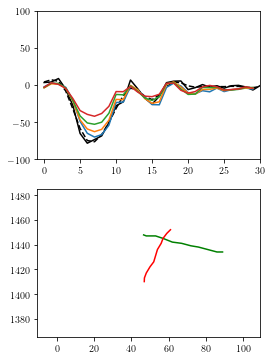

In [23]:

dataset = trajs_dbsharppH_flat
state = -1
while state != 4:
    numb = np.random.choice(np.arange(len(dataset)))
    state = np.argmax(model_fit._compute_posterior(data_dbsharppH_hmm[numb],0))
print(state, model_fit.means_[state])
#numb = 20134
b = dataset[numb]
plt.close("all")
fig,axis = plt.subplots(2,1,figsize =(4,6))
axis[0].plot(b.tailAngle*180.0/np.pi,'k-')
axis[0].plot(b.tailAngleSmoothed*180.0/np.pi,'k--')
sign = 1

axis[0].plot(sign*b.tailangles[:,0],'C0-')
axis[0].plot(sign*b.tailangles[:,1],'C1-')
axis[0].plot(sign*b.tailangles[:,2],'C2-')
axis[0].plot(sign*b.tailangles[:,3],'C3-')
axis[0].set_ylim(-100,100)
axis[0].set_xlim(-1,30)

bXsi = np.concatenate((b.posTailXVideoReferential[0],[b.posHeadX[0]]))
bYsi = np.concatenate((b.posTailYVideoReferential[0],[b.posHeadY[0]]))
bXsf = np.concatenate((b.posTailXVideoReferential[-1],[b.posHeadX[-1]]))
bYsf = np.concatenate((b.posTailYVideoReferential[-1],[b.posHeadY[-1]]))

axis[1].plot(bXsi,bYsi,'g-')
axis[1].plot(bXsf,bYsf,'r-')

zoom = 60
meanHeadX = np.mean(b.posHeadX)
meanHeadY = np.mean(b.posHeadY)
axis[1].set_xlim(meanHeadX-zoom,meanHeadX+zoom)
axis[1].set_ylim(meanHeadY-zoom,meanHeadY+zoom)
plt.show()

# Used to plot bout samples for each category shown in paper

6 [  5.53495866   8.03030826   1.79340663 -26.86626143  -6.45416784
   0.43081925]
35176 7.743945811447247 -0.0 9.939 0.125 1.202 1.242 9.614


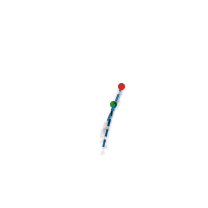

In [31]:
model_fit = GMM_model(7)
means_ = np.load("../Zebrafish_larvae/acid_means.npy")
covars_ = np.load("../Zebrafish_larvae/acid_covars.npy")
weights_ = np.load("../Zebrafish_larvae/acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

dataset = trajs_explo_flat
state = -1
while state != 6: #select bout type
    numb = np.random.choice(np.arange(len(dataset)))
    state = np.argmax(model_fit._compute_posterior(data_explo_hmm[numb],0))
print(state, model_fit.means_[state])

b = dataset[numb]
fac = 0
numps = 6
slopes = np.zeros(len(b.posHeadX))
slopes2 = np.zeros(len(b.posHeadX))
slopes3 = np.zeros(len(b.posHeadX))
delthetas = np.zeros(len(b.posHeadX))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,3))
print(numb,b.deltahead,-np.sum(delthetas),"%.3f %.3f %.3f %.3f %.3f" %(b.speed,b.time, b.disp, b.dist, b.disp/b.time))

for i in range(len(b.posHeadX)):
    tailx = b.posTailXVideoReferential[i]
    taily = b.posTailYVideoReferential[i]
    headx = b.posHeadX[i]
    heady = b.posHeadY[i]
#if i >= 13 and i < 16:
    numps = 8
    bXs = np.concatenate((tailx[-numps:],[b.posHeadX[i]]))
    bYs = np.concatenate((taily[-numps:],[b.posHeadY[i]]))
    p0 = np.polyfit(bXs,bYs,1)
    
    if i == 0 or i == len(b.posHeadX) -1:
        axis.plot(bXs + fac*i, p0[0]*bXs + p0[1] + fac*i,'C0--', lw = 2,alpha = 1)
        
    axis.plot(tailx[:] + fac*i,taily[:]+fac*i,'k.-',alpha = 0.025)
    if i == 0:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'C2o-', ms = 6,alpha = 1)
    elif i == len(b.posHeadX) -1:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'C3o-', ms = 6,alpha = 1)
    else:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'ko-', ms = 6,alpha = 0.025)

    slopes[i] = np.arctan2((bYs[-1]-bYs[0])*1,(bXs[-1]-bXs[0]))*180/np.pi
    slopes2[i] = np.arctan2((heady-taily[0]),(headx-tailx[0]))*180/np.pi
    slopes3[i] = np.arctan2((heady-taily[5]),(headx-tailx[5]))*180/np.pi

zoom = 75
meanHeadX = np.mean(b.posHeadX)
meanHeadY = np.mean(b.posHeadY)
axis.set_xlim(meanHeadX-zoom,meanHeadX+zoom)
axis.set_ylim(meanHeadY-zoom,meanHeadY+zoom)
plt.axis('off')
fig.tight_layout()
#plt.savefig("ff_example.pdf")
plt.show()    

# Histogram of fish length-wise location in acid and explo

1998.8


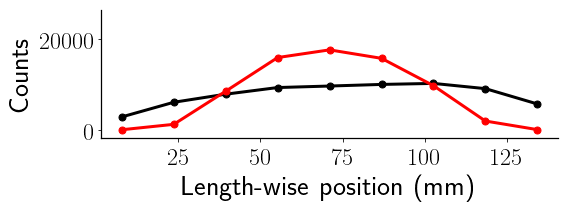

In [33]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,3))
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
axis.tick_params(labelsize = 24)

length_min = np.min([len(bouts_explo),len(bouts_dbsharppH)])
size =  length_min

posxs = []
posys = []
for b in bouts_explo[-length_min:]:
    posxs += [b.posHeadX[:1]]
    posys += [b.posHeadY[:1]]
posxs_flat = [item for sublist in posxs for item in sublist]
posys_flat = [item for sublist in posys for item in sublist]

n,bins = np.histogram(posys_flat, bins = np.linspace(0,2000,10), density = False)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins*px_to_mm,n, 'ko-',alpha = 1, label = "Exploratory", lw = 3, ms = 7)
print(np.max(posys_flat))
posxs = []
posys = []
for b in bouts_dbsharppH[:length_min]:
    posxs += [b.posHeadX[:1]]
    posys += [b.posHeadY[:1]]
posxs_flat = [item for sublist in posxs for item in sublist]
posys_flat = [item for sublist in posys for item in sublist]

n,bins = np.histogram(posys_flat, bins = np.linspace(0,2000,10), density =False)
bins = 0.5*(bins[1:] + bins[:-1])
axis.plot(bins*px_to_mm,n, 'ro-',alpha = 1, label = "Acid", lw = 3, ms=7)


axis.set_xlabel("Length-wise position (mm)", fontsize = 28)
axis.set_ylabel("Counts", fontsize = 28)
#axis.legend(loc = 2, fontsize = 18)
fig.tight_layout()
axis.set_ylim(-np.max(n)*0.1,np.max(n)*1.5)
#fig.savefig("histogram_xlocs_Dec19.pdf", dpi = 200)
plt.show()

# Fit a GMM to the dataset. Used to compute the held-out log likelihood vs number of clusters

In [38]:
model_fits = []
LLs = []
for i in range(3,11):
    print(i)
    model_fits += [[]]
    LLs += [[]]
    for j in range(5):
        model_fit = GMM_model(i)
        length_min = np.min([len(data_explo_hmm),len(data_dbsharppH_hmm)])
        size = 40000
        subsample_explo = np.random.choice(len(data_explo_hmm),size)
        subsample_dbsharppH = np.random.choice(len(data_dbsharppH_hmm),size)

        datasets = np.zeros((2,size,6))

        datasets[0] = data_explo_hmm[subsample_explo]
        datasets[1] = data_dbsharppH_hmm[subsample_dbsharppH]


        datasets_test = np.zeros((2,length_min - size,6))

        datasets_test[0] = np.delete(data_explo_hmm,subsample_explo,axis=0)[:length_min - size]
        datasets_test[1] = np.delete(data_dbsharppH_hmm,subsample_dbsharppH,axis=0)[:length_min - size]

        model_fit.solve(datasets)
        LLs[-1] += [model_fit.LL(datasets_test)]
        

3
Initial negative log-likelihood per sample = 22.8764
Final negative log-likelihood per sample = 19.0933
Number of iterations = 20
Initial negative log-likelihood per sample = 23.1805
Final negative log-likelihood per sample = 19.1359
Number of iterations = 21
Initial negative log-likelihood per sample = 22.6621
Final negative log-likelihood per sample = 19.0882
Number of iterations = 50
Initial negative log-likelihood per sample = 22.8779
Final negative log-likelihood per sample = 19.0458
Number of iterations = 19
Initial negative log-likelihood per sample = 22.8174
Final negative log-likelihood per sample = 19.1043
Number of iterations = 35
4
Initial negative log-likelihood per sample = 23.1693
Final negative log-likelihood per sample = 18.7887
Number of iterations = 21
Initial negative log-likelihood per sample = 23.0569
Final negative log-likelihood per sample = 18.7817
Number of iterations = 56
Initial negative log-likelihood per sample = 22.8641
Final negative log-likelihood per

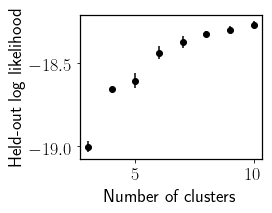

In [80]:
#Held-out log likelihood
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))
for i,ll in enumerate(LLs):
    axis.errorbar(i+3,-np.mean(ll),fmt='ko',yerr = np.std(ll))
    
axis.tick_params(labelsize = 18)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)

axis.set_xlabel("Number of clusters", fontsize = 18)
axis.set_ylabel("Held-out log likelihood", fontsize = 18)
fig.tight_layout()
#plt.savefig("figure_heldout_LL.pdf")
plt.show()

# Plot the tail angle and histograms of speed, duration, delta head for each bout category

In [34]:
trajs = trajs_explo_flat
speeds_explo = []
times_explo = []
deltaheads_explo = []
tails_explo = []
for i in range(len(model_fit.means_)):
    speeds_explo += [[]]
    times_explo += [[]]
    deltaheads_explo += [[]]
    tails_explo += [[]]
for i,b in enumerate(trajs[:]):
    state = np.argmax(model_fit._compute_posterior(data_explo_hmm[i],0))
    speeds_explo[state] += [trajs[i].speed]
    times_explo[state] +=  [trajs[i].time]
    deltaheads_explo[state] +=  [np.abs(trajs[i].deltahead)]
    tails_explo[state] += [trajs[i].tailangles[:,0]]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


23.72906435964083 0.2538863636363637 86.73518639568142 [0.01229131 0.03092058]
8.543023404754463 0.1600951757090012 19.738495837507365 [0.18765862 0.14406049]
10.238796679052351 0.16855314960629922 46.222495918943125 [0.12431775 0.1060592 ]
4.93361009861377 0.133899527647245 2.8473861477752744 [0.47544291 0.38883724]
13.620016717411149 0.20800189393939397 77.73191748779443 [0.05481023 0.06292705]
14.028229703398724 0.2024804006968641 31.702227606663172 [0.03407335 0.08673416]
8.466574018759154 0.17024720637876847 5.239246017191598 [0.11140582 0.18046127]


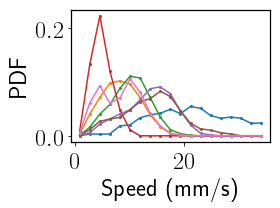

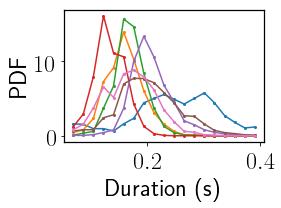

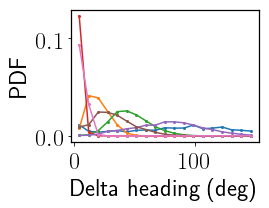

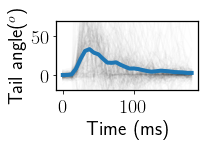

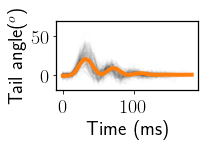

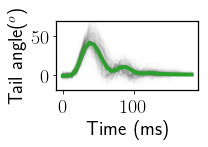

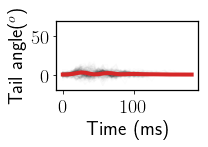

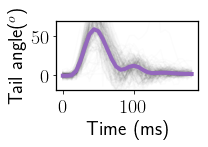

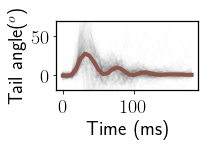

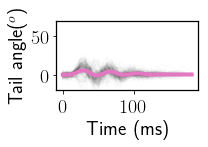

In [35]:
plt.close("all")
fig1,axis1= plt.subplots(1,1,figsize = (4,3))
fig2,axis2= plt.subplots(1,1,figsize = (4,3))
fig3,axis3= plt.subplots(1,1,figsize = (4,3))

for state in np.arange(7):
    
    n,bins = np.histogram(speeds_explo[state], bins = np.linspace(0,35,20), density = True)
    bins = 0.5*(bins[1:] + bins[:-1])
    axis1.plot(bins, n,'C%do-'%state, ms = 2)
    
    n,bins = np.histogram(times_explo[state], bins = np.linspace(0.06,0.4,20), density = True)
    bins = 0.5*(bins[1:] + bins[:-1])
    axis2.plot(bins, n,'C%do-'%state, ms = 2)
    
    n,bins = np.histogram(deltaheads_explo[state], bins = np.linspace(0,150,20), density = True)
    bins = 0.5*(bins[1:] + bins[:-1])
    axis3.plot(bins, n,'C%do-'%state, ms = 2)
    
    fg,ax=plt.subplots(1,1,figsize = (3,2))
    arr = np.array(tails_explo[state])
    arrs_fil0 = arr[np.mean(arr,axis=1) > 0]
    arrs_fil1 = arr[np.mean(arr,axis=1) < 0]
    
    for num in range(200):
        ax.plot(np.arange(len(arrs_fil0[num]))*1e3/fps,arrs_fil0[num],'k-',alpha = 0.01)
    ax.plot(np.arange(len(arrs_fil0[0]))*1e3/fps,np.mean(arrs_fil0,axis=0),'C%d'%state,lw = 4)

        
    ax.set_ylim(-20,70)
    ax.tick_params(labelsize = 20)
    ax.spines['top'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['right'].set_linewidth(1.25)
    ax.set_xlabel("Time (ms)", fontsize = 20)
    ax.set_ylabel(r"Tail angle($^o$)", fontsize = 20)
    fg.tight_layout()
    #fg.savefig("figure_tailangles_7clusters_tailanglespca_kin_%01d.pdf"%state)
    fg.show()
    print(np.mean(speeds_explo[state]),np.mean(times_explo[state]),np.mean(deltaheads_explo[state]), model_fit.weights_[:,state])

axis1.tick_params(labelsize = 24)
axis1.spines['top'].set_linewidth(1.25)
axis1.spines['left'].set_linewidth(1.25)
axis1.spines['bottom'].set_linewidth(1.25)
axis1.spines['right'].set_linewidth(1.25)
axis1.set_xlabel("Speed (mm/s)",fontsize = 24)
axis1.set_ylabel("PDF",fontsize = 24)
fig1.tight_layout()

axis2.tick_params(labelsize = 24)
axis2.spines['top'].set_linewidth(1.25)
axis2.spines['left'].set_linewidth(1.25)
axis2.spines['bottom'].set_linewidth(1.25)
axis2.spines['right'].set_linewidth(1.25)
axis2.set_xlabel("Duration (s)",fontsize = 24)
axis2.set_ylabel("PDF",fontsize = 24)
fig2.tight_layout()

axis3.tick_params(labelsize = 24)
axis3.spines['top'].set_linewidth(1.25)
axis3.spines['left'].set_linewidth(1.25)
axis3.spines['bottom'].set_linewidth(1.25)
axis3.spines['right'].set_linewidth(1.25)
axis3.set_xlabel("Delta heading (deg)",fontsize = 24)
axis3.set_ylabel("PDF",fontsize = 24)
fig3.tight_layout()

#fig1.savefig("speed_clusters_tailanglesPCA_and_kin.pdf")
#fig2.savefig("duration_clusters_tailanglesPCA_and_kin.pdf")
#fig3.savefig("deltahead_clusters_tailanglesPCA_and_kin.pdf")

plt.show()

# Plot bout category percentages

[ 1.2 18.8 12.4 47.5  5.5  3.4 11.1]
[ 3.1 14.4 10.6 38.9  6.3  8.7 18. ]


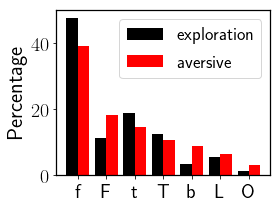

In [36]:
np.set_printoptions(precision = 1)
print(model_fit.weights_[0]*100)
print(model_fit.weights_[1]*100)

fig,axis= plt.subplots(1,1,figsize = (4,3))
axis.tick_params(labelsize = 20)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.set_ylabel(r"Percentage", fontsize = 22)
order = np.array([3,6,1,2,5,4,0])
axis.bar(np.arange(7) - 0.2,model_fit.weights_[0][order]*100, color ='k', width = 0.4, label = "exploration")
axis.bar(np.arange(7) + 0.2,model_fit.weights_[1][order]*100, color ='r', width = 0.4, label = "aversive")
axis.set_xticks(np.arange(7))
axis.set_xticklabels(['f','F','t','T','b','L','O'])
axis.legend(loc = 1, fontsize = 18)
fig.tight_layout() 
#fig.savefig("figure_cluster_weights.pdf")
plt.show()

# From here on, you need to first run the analyze BASS output files notebook and then load the below four .npy files. 

# Plot the directional bias of abnormal bouts

In [37]:
bouttypes_seg_dbsharppH = np.load("dbsharppH_data_segmented_bouttypes.npy")
words_seg_dbsharppH = np.load("dbsharppH_data_segmented_words.npy")
lnP_seg_dbsharppH = np.load("dbsharppH_data_segmented_words_lnP.npy")
abnormal_dbsharppH = np.load("dbsharppH_data_segmented_abnormal.npy")

delYs_normal =[]
delYs_normal2 =[]
delYs_abnormal = []
delYs_abnormal2 = []
delYs_abnormal3 = []
delYs_abs = []
for i in range(len(bouttypes_seg_dbsharppH)):
    t= trajs_dbsharppH_flat[i]
    if abnormal_dbsharppH[i] == 1:
        if words_seg_dbsharppH[i] == 71:
            if t.posHeadY[0] > 1000:
                delYs_abnormal2 += [t.posHeadY[-1] - t.posHeadY[0]]
            else:
                delYs_abnormal2 += [-t.posHeadY[-1] + t.posHeadY[0]]
        if words_seg_dbsharppH[i] != 71:
            
            if t.posHeadY[0] > 1500:
                delYs_abnormal3 += [t.posHeadY[-1] - t.posHeadY[0]]
            elif t.posHeadY[0] < 500:
                delYs_abnormal3 += [-t.posHeadY[-1] + t.posHeadY[0]]            
                
        if t.posHeadY[0] > 1000:
            delYs_abnormal += [t.posHeadY[-1] - t.posHeadY[0]]
        else:
            delYs_abnormal += [-t.posHeadY[-1] + t.posHeadY[0]]
            
    else:
        if t.posHeadY[0] > 1000:
            delYs_normal += [t.posHeadY[-1] - t.posHeadY[0]]
        else:
            delYs_normal += [-t.posHeadY[-1] + t.posHeadY[0]]
            
        if t.posHeadY[0] > 1500:
            delYs_normal2 += [t.posHeadY[-1] - t.posHeadY[0]]
        elif t.posHeadY[0] < 500:
            delYs_normal2 += [-t.posHeadY[-1] + t.posHeadY[0]] 
            
    delYs_abs += [np.abs(t.posHeadY[-1] - t.posHeadY[0])]
        

IndexError: list index out of range

0.7502419142300193 0.06304222307457742 0.008602686996967902 0.0060304050511120035 3078 62993
0.005235822289156457 0.028501865360967795 1.8453569104 0.1852149689605011 664 625
0.15641391713036576 0.027437334248182448 5032
1.1323536963569494


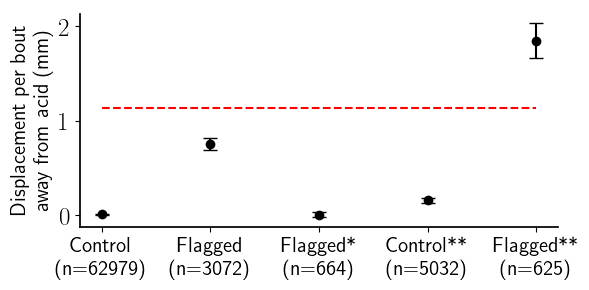

In [387]:
mean_abnormal = -np.mean(delYs_abnormal)*px_to_mm
ste_abnormal = np.std(delYs_abnormal)*px_to_mm/np.sqrt(len(delYs_abnormal))

mean_abnormal2 = -np.mean(delYs_abnormal2)*px_to_mm
ste_abnormal2 = np.std(delYs_abnormal2)*px_to_mm/np.sqrt(len(delYs_abnormal2))

mean_abnormal3 = -np.mean(delYs_abnormal3)*px_to_mm
ste_abnormal3 = np.std(delYs_abnormal3)*px_to_mm/np.sqrt(len(delYs_abnormal3))

mean_normal = -np.mean(delYs_normal)*px_to_mm
ste_normal = np.std(delYs_normal)*px_to_mm/np.sqrt(len(delYs_normal))

mean_normal2 = -np.mean(delYs_normal2)*px_to_mm
ste_normal2 = np.std(delYs_normal2)*px_to_mm/np.sqrt(len(delYs_normal2))

delYs_mean = np.mean(delYs_abs)*px_to_mm

print(mean_abnormal, ste_abnormal, mean_normal, ste_normal, len(delYs_abnormal),len(delYs_normal))
print(mean_abnormal2, ste_abnormal2, mean_abnormal3, ste_abnormal3, len(delYs_abnormal2),len(delYs_abnormal3))
print(mean_normal2, ste_normal2, len(delYs_normal2))
print(delYs_mean)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,3))
x = np.linspace(0,10,5)
y = [mean_normal, mean_abnormal, mean_abnormal2, mean_normal2, mean_abnormal3]
yerr = [ste_normal, ste_abnormal, ste_abnormal2, ste_normal2, ste_abnormal3]
axis.errorbar(x,y, yerr = yerr, c= 'k', fmt = 'o', capsize = 5)
axis.plot([0,10],[delYs_mean,delYs_mean], 'r--')

axis.tick_params(labelsize = 18)
axis.set_xticks(x)
axis.set_xticklabels(["Control\n(n=62979)", 'Flagged\n(n=3072)', 'Flagged*\n(n=664)', 'Control**\n(n=5032)', 'Flagged**\n(n=625)'], fontsize = 15)
axis.set_ylabel("Displacement per bout \n away from acid (mm)", fontsize = 15)
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
#fig.savefig("figure_directionality_acid.pdf")
plt.show()

# Extract "O" bouts used to escape acid

In [390]:
O_indices = []
b_indices = []
seq_indices = []
for i in range(len(bouttypes_seg_dbsharppH)):
    t = trajs_dbsharppH_flat[i]
    if abnormal_dbsharppH[i] == 1 and words_seg_dbsharppH[i] != 71 and (t.posHeadY[0] > 1500 or t.posHeadY[0] < 500):
        if bouttypes_seg_dbsharppH[i] == 0:
            O_indices += [i]
        elif bouttypes_seg_dbsharppH[i] == 5:
            b_indices += [i]
        if flag != 1:
            flag = 1
            j = i
            temp = []
            while abnormal_dbsharppH[j] == 1:
                temp += [j]
                j+=1
            seq_indices += [temp]
    else:
        flag = 0

[208, 209]


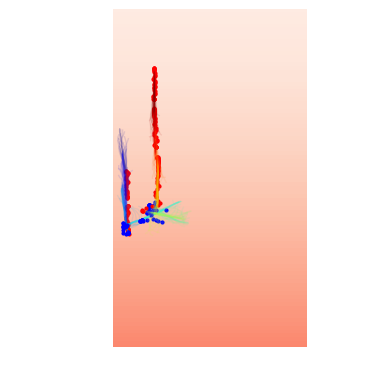

[1252, 1253]


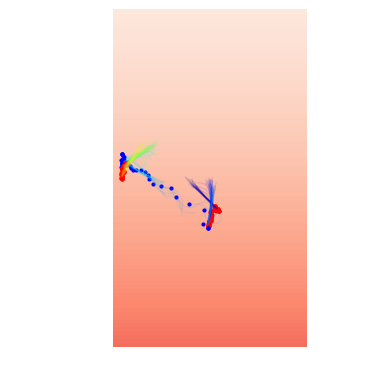

[1403, 1404]


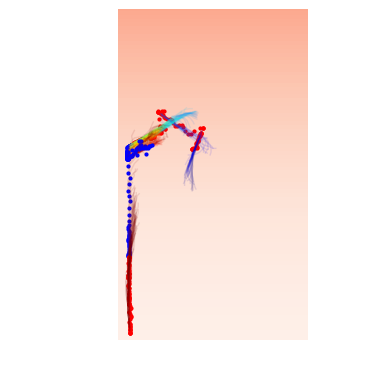

[1441, 1442]


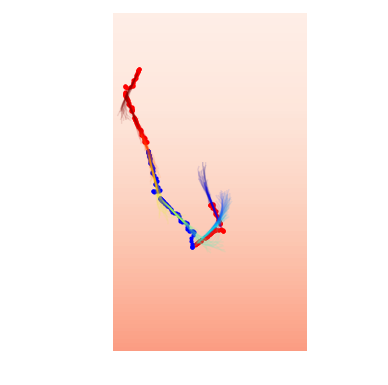

In [442]:
#Plot sequences artistically :D
zoom = 175
for k,seq in enumerate(seq_indices[:4]):
    bXs_all = []
    bYs_all = []
    flags_all = []
    print(seq)
    
    for ind in range(-3,len(seq)+3):
        index = seq[0] + ind
        b = trajs_dbsharppH_flat[index]
        for i in range(len(b.posHeadX)):
            bXs = np.concatenate((b.posTailXVideoReferential[i][:],[b.posHeadX[i]]))
            bYs = np.concatenate((b.posTailYVideoReferential[i][:],[b.posHeadY[i]]))
            bXs_all += [bXs]
            bYs_all += [bYs]
            if ind >=0 and ind < len(seq):
                flags_all += [1]
            else:
                flags_all += [0]
            
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (4,4))
    
    color = plt.cm.jet(np.arange(len(bXs_all)))

    for i in range(len(bXs_all)):
        bXs = bXs_all[i]
        bYs = bYs_all[i]
        axis.plot(bXs,bYs, '-',c=color[i], lw = 1, alpha = 0.1)
        if flags_all[i] == 1:
            axis.plot(bXs[-1],bYs[-1], 'bo',alpha = 1, ms = 2.0)
            #axis.plot(bXs,bYs, 'k-', lw = 1, alpha = 0.2)
        else:
            axis.plot(bXs[-1],bYs[-1], 'ro',alpha = 1, ms = 2.0)
        
    #axis.plot([b.posHeadX[i]],[b.posHeadY[i]],'ro')
    x = np.linspace(0,200,50)
    y = np.linspace(0,2000,50*10)
    xi,yi = np.meshgrid(x,y)
    zi = np.abs(1000 - yi)**3
    axis.imshow(zi, cmap = "Reds", extent = (0,200,0,2000), alpha = 0.8)
    
    axis.set_ylim(np.mean(bYs_all) - zoom,np.mean(bYs_all) + zoom)
    axis.set_xlim(100 - zoom,100 + zoom)
    fig.tight_layout()
    plt.axis('off')
    fig.savefig("./Plots_escapes/escape_seq%d.pdf"%k)
    plt.show()

# Plot segmented sequences in explo

29559


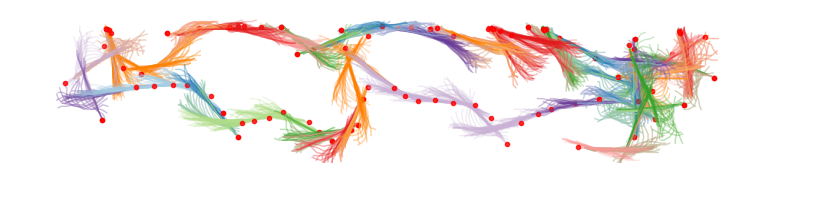

In [244]:
bouttypes_seg_explo = np.load("explo_data_segmented_bouttypes.npy")
words_seg_explo = np.load("explo_data_segmented_words.npy")
lnP_seg_explo = np.load("explo_data_segmented_words_lnP.npy")

length = 90
    
#start = np.random.randint(len(bouttypes_seg_explo)-length)
#print(start)
start = 1890
prevword = words_seg_explo[start]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (10,2))
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Paired_12.mpl_colors)))
bXs_all = []
bYs_all = []
heads_posX = []
heads_posY = []
index = 0
posXinit = trajs_explo_flat[start].posHeadX[0]
posYinit = trajs_explo_flat[start].posHeadY[0]
for ind in range(start, start+length):
    b= trajs_explo_flat[ind]
    for i in range(len(b.posHeadX)):
        bXs = np.concatenate((b.posTailXVideoReferential[i][:],[b.posHeadX[i]]))
        bYs = np.concatenate((b.posTailYVideoReferential[i][:],[b.posHeadY[i]]))
        bXs_all += [bXs]
        bYs_all += [bYs]
    heads_posX += [b.posHeadX[0]]
    heads_posY += [b.posHeadY[0]]
    
    currword = words_seg_explo[i]
    if currword != prevword:
        for i in range(len(bXs_all)):
            bXs0 = bXs_all[i]
            bYs0 = bYs_all[i]
            axis.plot(bYs0*px_to_mm,bXs0*px_to_mm, 'C%d-'%(index%10), lw = 1, alpha = 0.25)
        for i in range(len(heads_posX)):
            axis.plot(heads_posY[i]*px_to_mm,heads_posX[i]*px_to_mm, 'ro', ms=3, alpha = 0.8)
        index += 1
        bXs_all = []
        bYs_all = []
        heads_posX = []
        heads_posY = []
        for i in range(len(b.posHeadX)):
            bXs = np.concatenate((b.posTailXVideoReferential[i][:],[b.posHeadX[i]]))
            bYs = np.concatenate((b.posTailYVideoReferential[i][:],[b.posHeadY[i]]))
            bXs_all += [bXs]
            bYs_all += [bYs]  
        heads_posX += [b.posHeadX[0]]
        heads_posY += [b.posHeadY[0]]
        
    prevword = deepcopy(currword)
x = np.linspace(0,200,50)
y = np.linspace(0,2000,50*10)
xi,yi = np.meshgrid(x,y)
zi = np.abs(1000 - yi)**3

axis.set_ylim(50*px_to_mm,150*px_to_mm)
axis.set_xlim(posYinit*px_to_mm - 420*px_to_mm,posYinit*px_to_mm + 120*px_to_mm)
plt.axis('off')
#fig.savefig("figure_overview_segtrajectory.pdf")
plt.show()

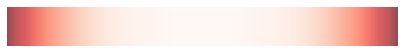

In [211]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (7,1))
x = np.linspace(0,200,50)
y = np.linspace(0,2000,50*10)
xi,yi = np.meshgrid(x,y)
zi = np.abs(1000 - yi)**3
axis.imshow(zi.T, cmap = "Reds", extent = (0,2000*px_to_mm,0,200*px_to_mm), alpha = 0.7)

axis.set_xticks([])
axis.set_yticks([])
plt.axis('off')
#fig.savefig("figure_acid_gradient.pdf")
plt.show()

# Raster plot showing the segmented bouts in acid, preferably of the same sequence shown in Figure 1b.

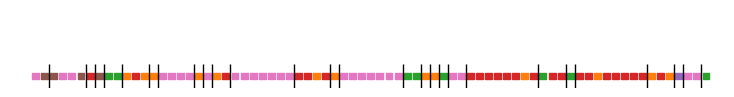

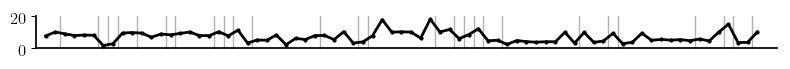

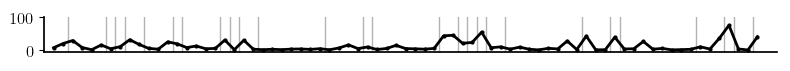

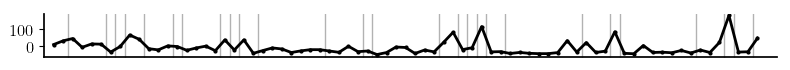

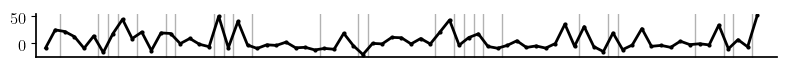

In [438]:

lsums = np.load("dbsharppH_data_segmented_lengths.npy")
bouttypes_seg_dbsharppH = np.load("dbsharppH_data_segmented_bouttypes.npy")
colors = []
for b in bouttypes_seg_dbsharppH:
    colors += ['C%d'%b]

mpl.rcdefaults()
rc('text', usetex=True)
L1=40000
L2=L1+75

speeds_raster = []
deltaheads_raster = []
tailpc1_raster = []
tailpc2_raster = []
for i in range(L1,L2):
    speeds_raster += [trajs_dbsharppH_flat[i].speed]
    deltaheads_raster += [np.abs(trajs_dbsharppH_flat[i].deltahead)]
    tailpc1_raster += [trajs_dbsharppH_flat[i].tailpc1]
    tailpc2_raster += [trajs_dbsharppH_flat[i].tailpc2]
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (9,1))
axis.scatter(np.arange(L1,L2),np.zeros(L2-L1),c = colors[L1:L2], s=25, marker = 's')
axis.set_xticks([])
axis.set_xlim(L1-1,L2+1)
axis.set_ylim(-0.5,3)
axis.plot(lsums-0.5,np.zeros(len(lsums)),marker = '|',lw=0,ms = 17,c='k')
axis.axis('off')    
#fig.savefig("bouttypes_raster.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,0.8))
axis.plot(np.arange(L1,L2),speeds_raster, c = 'k', ls='solid',marker = 'o',ms=2,lw=2)
axis.plot(lsums-0.5,np.ones(len(lsums)),marker = '|',lw=0,ms = 1000,c='k',alpha = 0.3)
axis.set_xticks([])
axis.set_xlim(L1-1,L2+1)
axis.set_ylim(0,20)
#axis.set_ylabel(r"Speed(mm/s)",fontsize = 10)
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
axis.tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig("speeds_raster.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,0.8))
axis.plot(np.arange(L1,L2),deltaheads_raster, c = 'k', ls='solid',marker = 'o',ms=2,lw=2)
axis.plot(lsums-0.5,np.ones(len(lsums)),marker = '|',lw=0,ms = 1000,c='k',alpha = 0.3)
axis.set_xticks([])
axis.set_xlim(L1-1,L2+1)
axis.set_ylim(-5,100)
#axis.set_ylabel(r"$|\Delta$Heading$|$(degs)",fontsize = 10)
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
axis.tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig("deltaheads_raster.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,0.8))
axis.plot(np.arange(L1,L2),tailpc1_raster, c = 'k', ls='solid',marker = 'o',ms=2,lw=2)
axis.plot(lsums-0.5,np.ones(len(lsums)),marker = '|',lw=0,ms = 1000,c='k',alpha = 0.3)
axis.set_xticks([])
axis.set_xlim(L1-1,L2+1)
#axis.set_ylabel(r"$|\Delta$Heading$|$(degs)",fontsize = 10)
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
axis.tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig("tailpc1_raster.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (8,0.8))
axis.plot(np.arange(L1,L2),tailpc2_raster, c = 'k', ls='solid',marker = 'o',ms=2,lw=2)
axis.plot(lsums-0.5,np.ones(len(lsums)),marker = '|',lw=0,ms = 1000,c='k',alpha = 0.3)
axis.set_xticks([])
axis.set_xlim(L1-1,L2+1)
#axis.set_ylabel(r"$|\Delta$Heading$|$(degs)",fontsize = 10)
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(0)
axis.tick_params(labelsize=12)
fig.tight_layout()
#fig.savefig("tailpc2_raster.pdf")
plt.show()

# Plot properties of bouts from flagged sequences

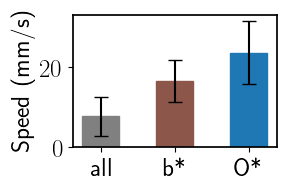

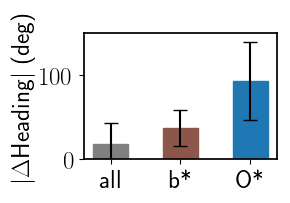

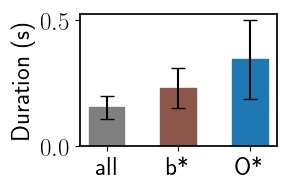

In [391]:
mpl.rcdefaults()
rc('text', usetex=True)

O_indices = []
b_indices = []
seq_indices = []
for i in range(len(bouttypes_seg_dbsharppH)):
    t = trajs_dbsharppH_flat[i]
    if abnormal_dbsharppH[i] == 1 and words_seg_dbsharppH[i] != 71 and (t.posHeadY[0] > 1500 or t.posHeadY[0] < 500):
        if bouttypes_seg_dbsharppH[i] == 0:
            O_indices += [i]
        elif bouttypes_seg_dbsharppH[i] == 5:
            b_indices += [i]
        if flag != 1:
            flag = 1
            j = i
            temp = []
            while abnormal_dbsharppH[j] == 1:
                temp += [j]
                j+=1
            seq_indices += [temp]
    else:
        flag = 0
        
        
bspeeds_flagged = []
bdeltaheads_flagged = []
btimes_flagged = []

Ospeeds_flagged = []
Odeltaheads_flagged = []
Otimes_flagged = []
for ind in b_indices:
    b=trajs_dbsharppH_flat[ind]
    bspeeds_flagged +=[b.speed]
    bdeltaheads_flagged += [np.abs(b.deltahead)]
    btimes_flagged += [b.time]
    
for ind in O_indices:
    b=trajs_dbsharppH_flat[ind]
    Ospeeds_flagged +=[b.speed]
    Odeltaheads_flagged += [np.abs(b.deltahead)]
    Otimes_flagged += [b.time]
    

x = np.arange(3)

yspeed = [np.mean(data_explo['speeds']), np.mean(bspeeds_flagged), np.mean(Ospeeds_flagged)]
yspeederr = [np.std(data_explo['speeds']), np.std(bspeeds_flagged),np.std(Ospeeds_flagged)]

ydeltahead = [np.mean(np.abs(data_explo['deltaheads'])), np.mean(bdeltaheads_flagged), np.mean(Odeltaheads_flagged)]
ydeltaheaderr = [np.std(np.abs(data_explo['deltaheads'])), np.std(bdeltaheads_flagged),np.std(Odeltaheads_flagged)]

ytime = [np.mean(data_explo['times']), np.mean(btimes_flagged), np.mean(Otimes_flagged)]
ytimeerr = [np.std(data_explo['times']), np.std(btimes_flagged),np.std(Otimes_flagged)]

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,2))
x = [0,0.2,0.4]
barlist = axis.bar(x, yspeed, width = 0.1, yerr = yspeederr, capsize = 5)
barlist[0].set_color('gray')
barlist[1].set_color('C5')
barlist[2].set_color('C0')
axis.set_ylabel("Speed (mm/s)", fontsize = 18)
axis.set_xticks(x)
axis.set_xticklabels(["all","b*", "O*"], fontsize = 18)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize=18)
fig.tight_layout()
#fig.savefig("figure_flagged_speed.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,2))
x = [0,0.2,0.4]
barlist = axis.bar(x, ydeltahead, width = 0.1, yerr = ydeltaheaderr, capsize = 5)
barlist[0].set_color('gray')
barlist[1].set_color('C5')
barlist[2].set_color('C0')
axis.set_ylabel(r"$|\Delta$Heading$|$ (deg)", fontsize = 18)
axis.set_xticks(x)
axis.set_xticklabels(["all","b*", "O*"], fontsize = 18)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize=18)
axis.set_ylim(0,150)
fig.tight_layout()
#fig.savefig("figure_flagged_deltahead.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,2))
x = [0,0.2,0.4]
barlist = axis.bar(x, ytime, width = 0.1, yerr = ytimeerr, capsize = 5)
barlist[0].set_color('gray')
barlist[1].set_color('C5')
barlist[2].set_color('C0')
axis.set_ylabel("Duration (s)", fontsize = 18)
axis.set_xticks(x)
axis.set_xticklabels(["all","b*", "O*"], fontsize = 18)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.tick_params(labelsize=18)
fig.tight_layout()
#fig.savefig("figure_flagged_time.pdf")
plt.show()
  

In [41]:
print(np.mean(bspeeds_flagged),np.std(bspeeds_flagged), np.mean(data_explo['speeds']), np.std(data_explo['speeds']))
print(np.mean(bdeltaheads_flagged),np.std(bdeltaheads_flagged), np.mean(np.abs(data_explo['deltaheads'])), np.std(np.abs(data_explo['deltaheads'])))
print(np.mean(btimes_flagged),np.std(btimes_flagged), np.mean(data_explo['times']), np.std(data_explo['times']))

17.372903302786376 6.325725630048069 7.701741017618246 4.809003168136164
39.311890612210526 24.756459093684636 17.672713835587047 24.735026921451084
0.23471283783783786 0.0823095024483688 0.15413953870193398 0.0464134721922893


In [42]:
print(np.mean(Ospeeds_flagged),np.std(Ospeeds_flagged), np.mean(data_explo['speeds']), np.std(data_explo['speeds']))
print(np.mean(Odeltaheads_flagged),np.std(Odeltaheads_flagged), np.mean(np.abs(data_explo['deltaheads'])), np.std(np.abs(data_explo['deltaheads'])))
print(np.mean(Otimes_flagged),np.std(Otimes_flagged), np.mean(data_explo['times']), np.std(data_explo['times']))

23.75768424737004 8.085572474748398 7.701741017618246 4.809003168136164
95.15954124951632 47.800019648043275 17.672713835587047 24.735026921451084
0.34743150684931506 0.16467796126114345 0.15413953870193398 0.0464134721922893


# plot samples of bouts from flagged sequences

5 [29.45948616 13.67898404  3.4337856  26.37412859 21.73785288 14.45681225]
23501 22.34118846931952 -0.0 18.177 0.300 5.272 5.453 17.573


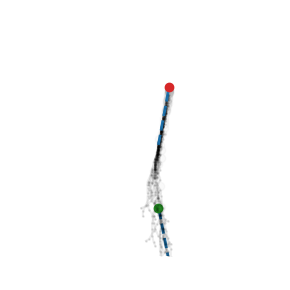

In [411]:
model_fit = GMM_model(7)
means_ = np.load("../Zebrafish_larvae/acid_means.npy")
covars_ = np.load("../Zebrafish_larvae/acid_covars.npy")
weights_ = np.load("../Zebrafish_larvae/acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

dataset = trajs_dbsharppH_flat
state = -1
while state != 5:
    numb = np.random.choice(np.arange(len(dataset)))
    #if not(numb in O_indices):
    #    continue
    if not(numb in b_indices):
        continue
    state = np.argmax(model_fit._compute_posterior(data_dbsharppH_hmm[numb],0))
print(state, model_fit.means_[state])
#numb = 25240
b = dataset[numb]
fac = 0
numps = 6
slopes = np.zeros(len(b.posHeadX))
slopes2 = np.zeros(len(b.posHeadX))
slopes3 = np.zeros(len(b.posHeadX))
delthetas = np.zeros(len(b.posHeadX))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (3,3))
print(numb,b.deltahead,-np.sum(delthetas),"%.3f %.3f %.3f %.3f %.3f" %(b.speed,b.time, b.disp, b.dist, b.disp/b.time))

for i in range(len(b.posHeadX)):
    tailx = b.posTailXVideoReferential[i]
    taily = b.posTailYVideoReferential[i]
    headx = b.posHeadX[i]
    heady = b.posHeadY[i]
#if i >= 13 and i < 16:
    numps = 8
    bXs = np.concatenate((tailx[-numps:],[b.posHeadX[i]]))
    bYs = np.concatenate((taily[-numps:],[b.posHeadY[i]]))
    p0 = np.polyfit(bXs,bYs,1)
    
    if i == 0 or i == len(b.posHeadX) -1:
        axis.plot(bXs + fac*i, p0[0]*bXs + p0[1] + fac*i,'C0--', lw = 2,alpha = 1)
        
    axis.plot(tailx[:] + fac*i,taily[:]+fac*i,'ko-',ms = 1,alpha = 0.07)
    if i == 0:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'C2o-', ms = 6,alpha = 1)
    elif i == len(b.posHeadX) -1:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'C3o-', ms = 6,alpha = 1)
    else:
        axis.plot([b.posHeadX[i] + fac*i],[b.posHeadY[i]+fac*i],'ko-', ms = 6,alpha = 0.025)

    slopes[i] = np.arctan2((bYs[-1]-bYs[0])*1,(bXs[-1]-bXs[0]))*180/np.pi
    slopes2[i] = np.arctan2((heady-taily[0]),(headx-tailx[0]))*180/np.pi
    slopes3[i] = np.arctan2((heady-taily[5]),(headx-tailx[5]))*180/np.pi
    #print(slopes[i],slopes2[i]-slopes[i],slopes3[i]-slopes[i])
    #print(bXs,p[0]*bXs + p[1])
        
#plt.plot(b.posHeadX[0] + np.arange(0,100),b.posHeadY[0] + np.arange(0,100),'C1--',alpha = 0.3)

zoom = 75
meanHeadX = np.mean(b.posHeadX)
meanHeadY = np.mean(b.posHeadY)
axis.set_xlim(meanHeadX-zoom,meanHeadX+zoom)
axis.set_ylim(meanHeadY-zoom,meanHeadY+zoom)
plt.axis('off')
fig.tight_layout()
plt.savefig("flagged_b_example4.pdf")
plt.show()    